<a href="https://colab.research.google.com/github/juno-yuu/MFE-DAML/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 2

### Question 1: Fixed effects and within transformation
#### You will find a modified version the imports-85.csv (imports85_modified.csv) file attached to this assignment. Again, make sure that all continuous variables of interest are numeric.






#### 1. Regress fuel efficiency (city.mpg) on horsepower without fixed effects. What would you conclude based on that regression?

In [ ]:
!pip install linearmodels
!pip install panel_ols

In [109]:
import os
import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import seaborn           as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
from linearmodels.panel import PanelOLS, FamaMacBeth
from patsy              import dmatrices

In [2]:
# To suppress false warnings with pandas
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# mount your Google Drive so you can locate your data files.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
df = pd.read_csv("/content/imports85_modified.csv")
df = df.rename(columns={"city.mpg":"citympg"})
df = df[['num.of.cylinders','horsepower','citympg']]
df = df.dropna()
df.head()

,num.of.cylinders,horsepower,citympg
0,four,111.0,10.5
1,four,111.0,10.5
2,six,154.0,28.5
3,four,102.0,12.0
4,five,115.0,27.0


In [84]:
model = smf.ols(formula='citympg ~ horsepower',data= df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                citympg   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     10.25
Date:                Thu, 08 Apr 2021   Prob (F-statistic):            0.00159
Time:                        22:18:58   Log-Likelihood:                -689.24
No. Observations:                 203   AIC:                             1382.
Df Residuals:                     201   BIC:                             1389.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2295      1.433      8.534      0.0

From the above regression, the baseline of the regession starts from 12.23 and fuel effcieny would increase 0.0411 for 1 unit horsepower increase.

#### 2. Repeat the same regression but this time, add a fixed effect for number of cylinders being “two” or “four”. What would you conclude based on this new regression? What do you think drives the results in part 1?

In [85]:
def conditions(x):
    if x == 'four':
        return 4
    elif x == 'two':
        return 2
    else:
        return 0
func = np.vectorize(conditions)
df['cylinders_2or4']=func(df['num.of.cylinders'])
df['cylinders_2or4'].head()

0    4
1    4
2    0
3    4
4    0
Name: cylinders_2or4, dtype: int64

In [86]:
df['cylinders_2or4']=df['cylinders_2or4'].astype(object)
model_dummy_cyl = smf.ols(formula='citympg ~ 1+ horsepower + C(cylinders_2or4)',data= df)
results = model_dummy_cyl.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                citympg   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     317.7
Date:                Thu, 08 Apr 2021   Prob (F-statistic):           1.34e-75
Time:                        22:19:08   Log-Likelihood:                -516.05
No. Observations:                 203   AIC:                             1040.
Df Residuals:                     199   BIC:                             1053.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 43

#### 3. (Within transformation) Now obtain the mean city.mpg and horsepower for each group. Use these group means to demean horsepower and city.mpg. Run the same regression you ran in part 1. Are the results different? Are the results obtained here different from the results in part 2? What does this tell you about the relation between fixed effect regressions and within transformations?

In [87]:
# creat a dataset for demeaned variable
df_demean = df.copy()

# calculate the citympg by cyl
df_demean['Mean_citympg_bycyl'] = df_demean.groupby('cylinders_2or4').citympg.transform(np.mean)

# calculate the horpower by cyl
df_demean['Mean_horsepower_bycyl'] = df_demean.groupby('cylinders_2or4').horsepower.transform(np.mean)

# demean, subtract each row by the entity-mean
df_demean["citympg"] = df_demean["citympg"] - df_demean['Mean_citympg_bycyl']
df_demean["horsepower"] = df_demean["horsepower"] - df_demean['Mean_horsepower_bycyl']


cylinders_2or4
0    28.250000
2     8.375000
4    13.585987
Name: citympg, dtype: float64
cylinders_2or4
0    154.97619
2    109.50000
4     90.55414
Name: horsepower, dtype: float64


In [91]:
model = sm.OLS(df_demean.citympg, df_demean.horsepower)
results2 = model.fit()
print(results2.summary())

                                 OLS Regression Results                                
Dep. Variable:                citympg   R-squared (uncentered):                   0.483
Model:                            OLS   Adj. R-squared (uncentered):              0.481
Method:                 Least Squares   F-statistic:                              189.0
Date:                Thu, 08 Apr 2021   Prob (F-statistic):                    8.62e-31
Time:                        22:24:08   Log-Likelihood:                         -516.05
No. Observations:                 203   AIC:                                      1034.
Df Residuals:                     202   BIC:                                      1037.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The results are different from the part 1 regression. But the $\beta$ is the same as the part 2. It would tell us that when introducing fixed effects into our regression, it would perform as if we are demeaning all variables at the cylinders level, which is to say that we are not explaining variation in  means across cylinders with beta.

### Question 2: On marginal significance and trading strategy improvements
#### You come up with a signal of stock outperformance: log total asset growth. You realize that your professor has conveniently already coded up this variable for you in the dataset StockRetAcct_insample.dta. The variable is called "lnInv".

#### 1. Using the Fama-MacBeth regression approach, what are the average return, standard deviation and Sharpe ratio of the trading strategy implied by using only an intercept and lnInv on the right hand side in the regressions?

In [190]:
# load data
StockRetAcct_DF= pd.read_csv("/content/StockRetAcct_DT.csv")
StockRetAcct_DF.head()

,Unnamed: 0,FirmID,year,lnAnnRet,lnRf,MEwt,lnIssue,lnMom,lnME,lnProf,lnEP,lnInv,lnLever,lnROE,rv,lnBM,ff_ind
0,1,6,1980,0.363631,0.078944,0.000281,0.031344,0.075355,12.581472,0.201767,0.146411,0.093626,0.696001,0.095294,0.084134,0.633391,3.0
1,2,6,1981,-0.290409,0.130199,0.000321,0.044213,0.512652,12.907996,0.215661,0.102555,0.087242,0.709843,0.082180,0.056381,0.356723,3.0
2,3,6,1982,0.186630,0.130703,0.000266,-0.068195,-0.220505,12.557775,0.184087,0.119548,0.111663,0.730972,0.079516,0.062072,0.779405,3.0
3,4,6,1983,0.489819,0.089830,0.000170,-0.071780,0.046218,12.561954,0.165531,0.115924,-0.033117,0.710885,0.055374,0.076955,0.702113,3.0
4,5,10,1991,-0.508005,0.061216,0.000033,0.115204,1.341053,11.565831,0.239788,0.023147,0.300051,0.418764,0.146828,0.374368,-2.160942,10.0


In [168]:
# Excess return, add a constant column for use in regressions
StockRetAcct_DF['ExRet'] = np.exp(StockRetAcct_DF.lnAnnRet)- np.exp(StockRetAcct_DF.lnRf)
StockRetAcct_DF['c']     = 1

In [167]:
StockRetAcct_DF['lnInv'].head()

0    0.093626
1    0.087242
2    0.111663
3   -0.033117
4    0.300051
Name: lnInv, dtype: float64

In [169]:
# define FMB regreesion
def fmreg(data,formula):
  return smf.ols(formula,data=data).fit().params[:]

# define output of the regression
def fm_summary(p):
  s = p.describe().T
  s['std_error'] = s['std']/np.sqrt(s['count'])
  s['tstat'] = s['mean']/s['std_error']
  s['Sharpe Ratio'] = s['mean']/s['std']
  return s[['mean','std','tstat','Sharpe Ratio']]

out = StockRetAcct_DF.groupby('year').apply(fmreg,'ExRet ~ lnInv')
fm_summary(out)

,mean,std,tstat,Sharpe Ratio
Intercept,0.107785,0.183065,3.483271,0.588780
lnInv,-0.086791,0.148644,-3.454326,-0.583888


#### 2. What is the analytical expression for the portfolio weights in this case? (I'm looking for a formula)

$\lambda = \sum^N_{i=1}\frac{1}{N}\frac{(x_{i,t-1}-E_N[x_{i,t-1}])}{Var_N[x_{i,t-1}]}R_{i,t}$

#### 3. You worry that there is industry-related noise associated with the characteristic lnInv and want to clean up your trading strategy with the goal of reducing exposure to unpriced industry risks. What regressions to you run? Report mean, standard deviation, and Sharpe ratio of the 'cleaned-up' trading strategy.

To reduce the industry noise risk, I would run regression with industry dummies in the Fama-MacBeth regression.

In [170]:

# Add industry dummies
StockRetAcct_DF['Industry']=StockRetAcct_DF['ff_ind'].astype(object)
# run FMB regression
out1 = (StockRetAcct_DF.groupby('year').apply(fmreg,'ExRet~ lnInv+Industry'))
fm_summary(out1)

,mean,std,tstat,Sharpe Ratio
Intercept,0.112763,0.193545,3.446823,0.582619
Industry[T.2.0],-0.012202,0.130250,-0.554223,-0.093681
Industry[T.3.0],-0.016387,0.129407,-0.749142,-0.126628
Industry[T.4.0],-0.029597,0.297996,-0.587584,-0.099320
Industry[T.5.0],-0.001101,0.098524,-0.066126,-0.011177
Industry[T.6.0],0.006305,0.280174,0.133133,0.022504
Industry[T.7.0],0.023252,0.217234,0.633249,0.107039
Industry[T.8.0],-0.018057,0.143258,-0.745693,-0.126045
Industry[T.9.0],0.008121,0.093976,0.511272,0.086421
Industry[T.10.0],0.029135,0.184509,0.934180,0.157905


#### 4. As in the class notes, plot the cumulative returns to the simple and the 'cleaned-up' trading strategies based on your new signal, lnInv. Make sure both trading strategies result in portfolios with a 15% return standard deviation.

[Text(0, 0.5, 'Cumulative Return'),
 Text(0.5, 0, 'Year'),
 Text(0.5, 1.0, 'Old Value vs New Value')]

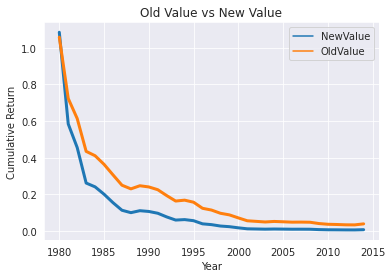

In [171]:
lnInvstdev = out1['lnInv'].std()
lnInvret = out1['lnInv']
# for plotting, get the scaled excess portfolio returns
lnInv_ret = lnInvret*0.15/lnInvstdev

# create cumulative log return series
cum_ret_lnInv = pd.DataFrame.cumsum(np.log(1+lnInv_ret))

# get "old" simple value strategy returns
lnInvstdev = out['lnInv'].std()
lnInvret = out1['lnInv']
lnInv_old_ret = pd.DataFrame.cumsum(np.log(1+lnInvret*0.15/lnInvstdev))

summary = pd.DataFrame()
summary['NewValue'] = np.exp(cum_ret_lnInv)
summary['OldValue'] = np.exp(lnInv_old_ret)

# Plot Old Value vs New Value
sns.set_style('darkgrid')
plt.figure()
ax=sns.lineplot(data=summary,dashes = False,linewidth = 3)
ax.set(xlabel = 'Year',
ylabel = 'Cumulative Return',
title = "Old Value vs New Value")

### Question 3: Predicting medium to long-run firm-level return variance

#### There are many return volatility models, such as GARCH. These work best at shorter horizons. As an alternative, we will explore a panel regression approach to predicting firmlevel return variance. The data set StockRetAcct_insample.dta has annual realized variance (rv), calculated as the sum of squared daily returns to each firm, each year.

#### Run panel forecasting regressions to forecast firm-level one-year ahead rv along the lines of what we did with lnROE in class.

#### 1. Try with and without industry and year fixed effects, with and without clustering of standard errors. Discuss which specification makes most sense to you. In particular, discuss the effect of a year fixed effect. What is the intuition for the impact of this fixed effect?

In [191]:
#get lead_rv
StockRetAcct_DF['lead_rv']= StockRetAcct_DF.groupby('FirmID')['rv'].shift(-1)
StockRetAcct_DF=StockRetAcct_DF[~StockRetAcct_DF.ff_ind.isna()]
StockRetAcct_DF['year_col'] = StockRetAcct_DF['year']
StockRetAcct_DF = StockRetAcct_DF.set_index(['FirmID','year'])
# Regression with no FE or SE
rv_panel = PanelOLS.from_formula(formula='lead_rv ~ 1+rv', data=StockRetAcct_DF).fit()
print("no FE or SE", rv_panel)

no FE or SE                           PanelOLS Estimation Summary                           
Dep. Variable:                lead_rv   R-squared:                        0.2629
Estimator:                   PanelOLS   R-squared (Between):              0.5283
No. Observations:               55654   R-squared (Within):               0.0017
Date:                Fri, Apr 09 2021   R-squared (Overall):              0.2629
Time:                        00:12:01   Log-likelihood                 2.598e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.985e+04
Entities:                        6081   P-value                           0.0000
Avg Obs:                       9.1521   Distribution:                 F(1,55652)
Min Obs:                       1.0000                                           
Max Obs:                       34.000   F-statistic (robust):          1.985e+04
                

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [192]:
# Regression with no FE, standard errors clustered at the firm level
rv_panel2 = PanelOLS.from_formula(formula='lead_rv ~ 1+rv', data = StockRetAcct_DF).fit(cov_type = 'clustered', cluster_entity=True, cluster_time=False)
print("no FE,clustered at Firm Level",rv_panel2)

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


no FE,clustered at Firm Level                           PanelOLS Estimation Summary                           
Dep. Variable:                lead_rv   R-squared:                        0.2629
Estimator:                   PanelOLS   R-squared (Between):              0.5283
No. Observations:               55654   R-squared (Within):               0.0017
Date:                Fri, Apr 09 2021   R-squared (Overall):              0.2629
Time:                        00:12:35   Log-likelihood                 2.598e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.985e+04
Entities:                        6081   P-value                           0.0000
Avg Obs:                       9.1521   Distribution:                 F(1,55652)
Min Obs:                       1.0000                                           
Max Obs:                       34.000   F-statistic (robust):             4370.

By compare to $Panel \ 1$ regression, $R^2$ does not change but a smaller t-stat.

In [186]:
# Regression with no FE, standard errors clustered at the firm and year level
rv_panel3 = PanelOLS.from_formula(formula='lead_rv ~ 1+rv', data = StockRetAcct_DF).fit(cov_type = 'clustered', cluster_entity=True, cluster_time=True)
print(rv_panel3)

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:                lead_rv   R-squared:                        0.2629
Estimator:                   PanelOLS   R-squared (Between):              0.5283
No. Observations:               55654   R-squared (Within):               0.0017
Date:                Fri, Apr 09 2021   R-squared (Overall):              0.2629
Time:                        00:10:03   Log-likelihood                 2.598e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   1.985e+04
Entities:                        6081   P-value                           0.0000
Avg Obs:                       9.1521   Distribution:                 F(1,55652)
Min Obs:                       1.0000                                           
Max Obs:                       34.000   F-statistic (robust):             8.5179
                            

Compaare to $Panel \ 1 $ and $Panel \ 2$, by clustering by time does not change $R^2$, but greatly reduced t-stat, which is the evidence of both firm and time dependencies in the errors.

In [193]:
# Regression with industry FE, standard errors clustered at the year level
rv_panel4 = PanelOLS.from_formula(formula='lead_rv~1+rv+C(ff_ind)',data = StockRetAcct_DF).fit(cov_type = 'clustered', cluster_entity=False, cluster_time=True)
print(rv_panel4)

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:                lead_rv   R-squared:                        0.2837
Estimator:                   PanelOLS   R-squared (Between):              0.5489
No. Observations:               55654   R-squared (Within):               0.0208
Date:                Fri, Apr 09 2021   R-squared (Overall):              0.2837
Time:                        00:18:45   Log-likelihood                 2.678e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1836.8
Entities:                        6081   P-value                           0.0000
Avg Obs:                       9.1521   Distribution:                F(12,55641)
Min Obs:                       1.0000                                           
Max Obs:                       34.000   F-statistic (robust):             40.334
                            

By inducing fixed effect at the industry level, $R^2$ slightly increased.

In [183]:
# Regression with time and industry FE, standard errors clustered at the firm 
# and year level
rv_panel5 = PanelOLS.from_formula(formula='lead_rv ~ 1+rv+C(ff_ind)+TimeEffects', data = StockRetAcct_DF).fit(cov_type = 'clustered', cluster_entity=True, cluster_time=True)
print(rv_panel5)

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:                lead_rv   R-squared:                        0.3951
Estimator:                   PanelOLS   R-squared (Between):              0.5985
No. Observations:               55654   R-squared (Within):              -0.0385
Date:                Fri, Apr 09 2021   R-squared (Overall):              0.2717
Time:                        00:07:20   Log-likelihood                 4.457e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3026.4
Entities:                        6081   P-value                           0.0000
Avg Obs:                       9.1521   Distribution:                F(12,55608)
Min Obs:                       1.0000                                           
Max Obs:                       34.000   F-statistic (robust):             48.150
                            

In this case, $R^2$ increased to around $39\%$, and most of the variables are significant, which can see that the time-series variation of beta is significant.

#### 2. Also try forecasting at the 5-year horizon (rv in 5 years). How do the results change? Can we predict return variance 5-years ahead? Is the 5-year lagged rv significant, or are other variables more important?

In [197]:
# creat 5-year lead rv
StockRetAcct_DF['lead_rv5'] = StockRetAcct_DF.groupby('FirmID')['rv'].shift(-5)
# Industry component in accounting variables, include industry FE,
# standard errors clustered at the firm and year level
rv_panel6 = PanelOLS.from_formula(formula='lead_rv5~1+rv+C(ff_ind)+TimeEffects',data = StockRetAcct_DF).fit(cov_type = 'clustered',
cluster_entity=True, cluster_time=True)
print(rv_panel6)

/usr/local/lib/python3.7/dist-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:               lead_rv5   R-squared:                        0.1191
Estimator:                   PanelOLS   R-squared (Between):              0.1329
No. Observations:               36076   R-squared (Within):              -0.1224
Date:                Fri, Apr 09 2021   R-squared (Overall):              0.0166
Time:                        00:35:35   Log-likelihood                 2.484e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      406.12
Entities:                        3556   P-value                           0.0000
Avg Obs:                       10.145   Distribution:                F(12,36034)
Min Obs:                       1.0000                                           
Max Obs:                       30.000   F-statistic (robust):             20.764
                            

The $R^2$ of this variable is quite a bit lower, around $12\%$. We would still do prediction in 5 year, but the accuracy can not be guaranteed. There are quite a lot variables are significant, especially rv in 5 years is significant. 

#### 3. What are the benefits of the panel approach, versus simply running one regression for each firm? What are the potential costs?

Panel regression estimates usually will have a big increase in power, regression coefficients have low standard error. However, requires assumption that regression coefficients are constant over time
and in cross-section (potentially with exception of intercepts)